In [1]:
# Transformers installation
# ! pip install transformers datasets
!pip install speechbrain
# To install from source instead of the last release, comment the command above and uncomment the following one.
! pip install git+https://github.com/huggingface/transformers.git

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 553.8/553.8 kB 7.8 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.6/109.6 kB 7.9 MB/s eta 0:00:00
  Attempting uninstall: ruamel.yaml
    Found existing installation: ruamel.yaml 0.17.32
    Uninstalling ruamel.yaml-0.17.32:
      Successfully uninstalled ruamel.yaml-0.17.32
  Cloning https://github.com/huggingface/transformers.git to /tmp/pip-req-build-0053rrk1
  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/transformers.git /tmp/pip-req-build-0053rrk1
  Resolved https://github.com/huggingface/transformers.git to commit 686c68f64c9d0181bd54d4d2e2446543c3eca1fa
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for transformers: filename=transformers-4.33.0.dev0-py3-none-any.whl size=7587722 sha256=7adeb96cb476d0160283f558b7c06f80f583e51266c9d10ec79ef9de76e76922
  Stored in dire

# Text to speech

Text-to-speech (TTS) is the task of creating natural-sounding speech from text, where the speech can be generated in multiple
languages and for multiple speakers. The only text-to-speech model currently available in 🤗 Transformers
is [SpeechT5](https://huggingface.co/docs/transformers/main/en/tasks/model_doc/speecht5), though more will be added in the future. SpeechT5 is pre-trained on a combination of
speech-to-text and text-to-speech data, allowing it to learn a unified space of hidden representations shared by both text
and speech. This means that the same pre-trained model can be fine-tuned for different tasks. Furthermore, SpeechT5
supports multiple speakers through x-vector speaker embeddings.

This guide illustrates how to:

1. Fine-tune [SpeechT5](https://huggingface.co/docs/transformers/main/en/tasks/model_doc/speecht5) that was originally trained on English speech on the Dutch (`nl`) language subset of the [VoxPopuli](https://huggingface.co/datasets/facebook/voxpopuli) dataset.
2. Use your fine-tuned model for inference.

Before you begin, make sure you have all the necessary libraries installed:

```bash
pip install datasets soundfile speechbrain accelerate
```

Install 🤗Transformers from source as not all the SpeechT5 features have been merged into an official release yet:

```bash
pip install git+https://github.com/huggingface/transformers.git
```

<Tip>

To follow this guide you will need a GPU. If you're working in a notebook, run the following line to check if a GPU is available:

```bash
!nvidia-smi
```

</Tip>

We encourage you to log in to your Hugging Face account to upload and share your model with the community. When prompted, enter your token to log in:

In [30]:
from huggingface_hub import notebook_login

notebook_login()

## Load the dataset

[VoxPopuli](https://huggingface.co/datasets/facebook/voxpopuli) is a large-scale multilingual speech corpus consisting of
data sourced from 2009-2020 European Parliament event recordings. It contains labelled audio-transcription data for 15
European languages. In this guide, we are using the Dutch language subset, feel free to pick another subset.

Note that VoxPopuli or any other automated speech recognition (ASR) dataset may not be the most suitable
option for training TTS models. The features that make it beneficial for ASR, such as excessive background noise, are
typically undesirable in TTS. However, finding top-quality, multilingual, and multi-speaker TTS datasets can be quite
challenging.

Let's load the data:

In [57]:
from datasets import load_dataset, Audio

dataset = load_dataset("facebook/voxpopuli", "nl", split="train")
dataset

Dataset({
    features: ['audio_id', 'language', 'audio', 'raw_text', 'normalized_text', 'gender', 'speaker_id', 'is_gold_transcript', 'accent'],
    num_rows: 20968
})

20968 examples should be sufficient for fine-tuning. SpeechT5 expects audio data to have a sampling rate of 16 kHz, so
make sure the examples in the dataset meet this requirement:

In [56]:
dataset = dataset.cast_column("audio", Audio(sampling_rate=16000))
dataset

Dataset({
    features: ['audio_id', 'language', 'audio', 'raw_text', 'normalized_text', 'gender', 'speaker_id', 'is_gold_transcript', 'accent'],
    num_rows: 20968
})

In [59]:
dataset[0]

{'audio_id': '20100210-0900-PLENARY-3-nl_20100210-09:06:43_4',
 'language': 9,
 'audio': {'path': '/root/.cache/huggingface/datasets/downloads/extracted/02ec6a19d5b97c03e1379250378454dbf3fa2972943504a91c7da5045aa26a89/train_part_0/20100210-0900-PLENARY-3-nl_20100210-09:06:43_4.wav',
  'array': array([ 4.27246094e-04,  1.31225586e-03,  1.03759766e-03, ...,
         -9.15527344e-05,  7.62939453e-04, -2.44140625e-04]),
  'sampling_rate': 16000},
 'raw_text': 'Dat kan naar mijn gevoel alleen met een brede meerderheid die wij samen zoeken.',
 'normalized_text': 'dat kan naar mijn gevoel alleen met een brede meerderheid die wij samen zoeken.',
 'gender': 'female',
 'speaker_id': '1122',
 'is_gold_transcript': True,
 'accent': 'None'}

In [69]:
dataset[0]["normalized_text"]

'dat kan naar mijn gevoel alleen met een brede meerderheid die wij samen zoeken.'

In [67]:
from IPython.display import Audio

Audio(dataset[0]["audio"]["array"], rate=dataset[0]["audio"]["sampling_rate"])

## Preprocess the data

Let's begin by defining the model checkpoint to use and loading the appropriate processor:

In [5]:
from transformers import SpeechT5Processor

checkpoint = "microsoft/speecht5_tts"
processor = SpeechT5Processor.from_pretrained(checkpoint)

### Text cleanup for SpeechT5 tokenization

Start by cleaning up the text data. You'll need the tokenizer part of the processor to process the text:

In [6]:
tokenizer = processor.tokenizer

The dataset examples contain `raw_text` and `normalized_text` features. When deciding which feature to use as the text input,
consider that the SpeechT5 tokenizer doesn't have any tokens for numbers. In `normalized_text` the numbers are written
out as text. Thus, it is a better fit, and we recommend using    `normalized_text` as input text.

Because SpeechT5 was trained on the English language, it may not recognize certain characters in the Dutch dataset. If
left as is, these characters will be converted to `<unk>` tokens. However, in Dutch, certain characters like `à` are
used to stress syllables. In order to preserve the meaning of the text, we can replace this character with a regular `a`.

To identify unsupported tokens, extract all unique characters in the dataset using the `SpeechT5Tokenizer` which
works with characters as tokens. To do this, write the `extract_all_chars` mapping function that concatenates
the transcriptions from all examples into one string and converts it to a set of characters.
Make sure to set `batched=True` and `batch_size=-1` in `dataset.map()` so that all transcriptions are available at once for
the mapping function.

In [7]:
def extract_all_chars(batch):
    all_text = " ".join(batch["normalized_text"])
    vocab = list(set(all_text))
    return {"vocab": [vocab], "all_text": [all_text]}


vocabs = dataset.map(
    extract_all_chars,
    batched=True,
    batch_size=-1,
    keep_in_memory=True,
    remove_columns=dataset.column_names,
)

dataset_vocab = set(vocabs["vocab"][0])
tokenizer_vocab = {k for k, _ in tokenizer.get_vocab().items()}

  0%|          | 0/1 [00:00<?, ?ba/s]

Now you have two sets of characters: one with the vocabulary from the dataset and one with the vocabulary from the tokenizer.
To identify any unsupported characters in the dataset, you can take the difference between these two sets. The resulting
set will contain the characters that are in the dataset but not in the tokenizer.

In [8]:
dataset_vocab - tokenizer_vocab

{' ', 'à', 'ç', 'è', 'ë', 'í', 'ï', 'ö', 'ü'}

To handle the unsupported characters identified in the previous step, define a function that maps these characters to
valid tokens. Note that spaces are already replaced by `▁` in the tokenizer and don't need to be handled separately.

In [9]:
replacements = [
    ("à", "a"),
    ("ç", "c"),
    ("è", "e"),
    ("ë", "e"),
    ("í", "i"),
    ("ï", "i"),
    ("ö", "o"),
    ("ü", "u"),
]


def cleanup_text(inputs):
    for src, dst in replacements:
        inputs["normalized_text"] = inputs["normalized_text"].replace(src, dst)
    return inputs


dataset = dataset.map(cleanup_text)

  0%|          | 0/20968 [00:00<?, ?ex/s]

Now that you have dealt with special characters in the text, it's time to shift focus to the audio data.

### Speakers

The VoxPopuli dataset includes speech from multiple speakers, but how many speakers are represented in the dataset? To
determine this, we can count the number of unique speakers and the number of examples each speaker contributes to the dataset.
With a total of 20,968 examples in the dataset, this information will give us a better understanding of the distribution of
speakers and examples in the data.

In [10]:
from collections import defaultdict

speaker_counts = defaultdict(int)

for speaker_id in dataset["speaker_id"]:
    speaker_counts[speaker_id] += 1

By plotting a histogram you can get a sense of how much data there is for each speaker.

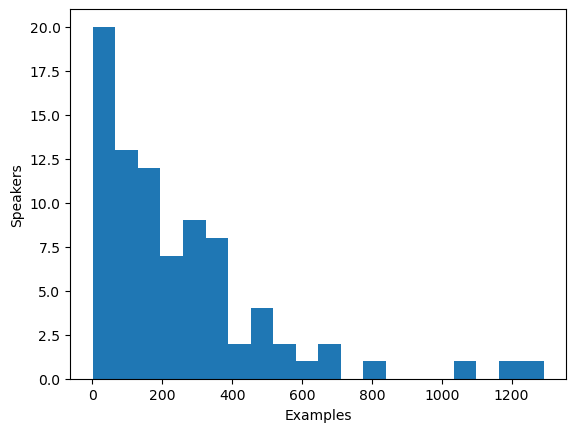

In [11]:
import matplotlib.pyplot as plt

plt.figure()
plt.hist(speaker_counts.values(), bins=20)
plt.ylabel("Speakers")
plt.xlabel("Examples")
plt.show()

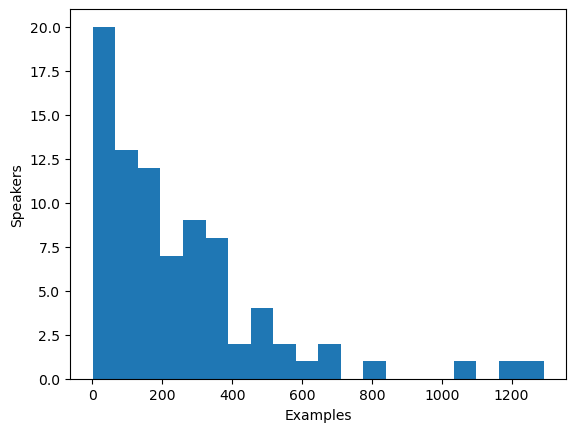<div class="flex justify-center">
    <img src="https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/transformers/tasks/tts_speakers_histogram.png" alt="Speakers histogram"/>
</div>

The histogram reveals that approximately one-third of the speakers in the dataset have fewer than 100 examples, while
around ten speakers have more than 500 examples. To improve training efficiency and balance the dataset, we can limit
the data to speakers with between 100 and 400 examples.

In [12]:
def select_speaker(speaker_id):
    return 100 <= speaker_counts[speaker_id] <= 400


dataset = dataset.filter(select_speaker, input_columns=["speaker_id"])

  0%|          | 0/21 [00:00<?, ?ba/s]

Let's check how many speakers remain:

In [13]:
len(set(dataset["speaker_id"]))

42

Let's see how many examples are left:

In [14]:
len(dataset)

9973

You are left with just under 10,000 examples from approximately 40 unique speakers, which should be sufficient.

Note that some speakers with few examples may actually have more audio available if the examples are long. However,
determining the total amount of audio for each speaker requires scanning through the entire dataset, which is a
time-consuming process that involves loading and decoding each audio file. As such, we have chosen to skip this step here.

### Speaker embeddings

To enable the TTS model to differentiate between multiple speakers, you'll need to create a speaker embedding for each example.
The speaker embedding is an additional input into the model that captures a particular speaker's voice characteristics.
To generate these speaker embeddings, use the pre-trained [spkrec-xvect-voxceleb](https://huggingface.co/speechbrain/spkrec-xvect-voxceleb)
model from SpeechBrain.

Create a function `create_speaker_embedding()` that takes an input audio waveform and outputs a 512-element vector
containing the corresponding speaker embedding.

In [15]:
!pip install speechbrain

In [16]:
import os
import torch
from speechbrain.pretrained import EncoderClassifier

spk_model_name = "speechbrain/spkrec-xvect-voxceleb"

device = "cuda" if torch.cuda.is_available() else "cpu"
speaker_model = EncoderClassifier.from_hparams(
    source=spk_model_name,
    run_opts={"device": device},
    savedir=os.path.join("/tmp", spk_model_name),
)


def create_speaker_embedding(waveform):
    with torch.no_grad():
        speaker_embeddings = speaker_model.encode_batch(torch.tensor(waveform))
        speaker_embeddings = torch.nn.functional.normalize(speaker_embeddings, dim=2)
        speaker_embeddings = speaker_embeddings.squeeze().cpu().numpy()
    return speaker_embeddings

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


It's important to note that the `speechbrain/spkrec-xvect-voxceleb` model was trained on English speech from the VoxCeleb
dataset, whereas the training examples in this guide are in Dutch. While we believe that this model will still generate
reasonable speaker embeddings for our Dutch dataset, this assumption may not hold true in all cases.

For optimal results, we recommend training an X-vector model on the target speech first. This will ensure that the model
is better able to capture the unique voice characteristics present in the Dutch language.

### Processing the dataset

Finally, let's process the data into the format the model expects. Create a `prepare_dataset` function that takes in a
single example and uses the `SpeechT5Processor` object to tokenize the input text and load the target audio into a log-mel spectrogram.
It should also add the speaker embeddings as an additional input.

In [17]:
def prepare_dataset(example):
    audio = example["audio"]

    example = processor(
        text=example["normalized_text"],
        audio_target=audio["array"],
        sampling_rate=audio["sampling_rate"],
        return_attention_mask=False,
    )

    # strip off the batch dimension
    example["labels"] = example["labels"][0]

    # use SpeechBrain to obtain x-vector
    example["speaker_embeddings"] = create_speaker_embedding(audio["array"])

    return example

Verify the processing is correct by looking at a single example:

In [18]:
processed_example = prepare_dataset(dataset[0])
list(processed_example.keys())

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

['input_ids', 'labels', 'speaker_embeddings']

Speaker embeddings should be a 512-element vector:

In [19]:
processed_example["speaker_embeddings"].shape

(512,)

The labels should be a log-mel spectrogram with 80 mel bins.

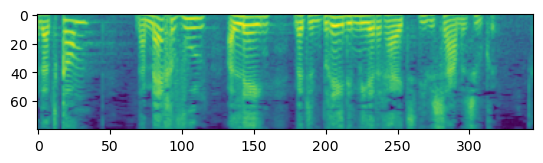

In [20]:
import matplotlib.pyplot as plt

plt.figure()
plt.imshow(processed_example["labels"].T)
plt.show()

<div class="flex justify-center">
    <img src="https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/transformers/tasks/tts_logmelspectrogram_1.png" alt="Log-mel spectrogram with 80 mel bins"/>
</div>

Side note: If you find this spectrogram confusing, it may be due to your familiarity with the convention of placing low frequencies
at the bottom and high frequencies at the top of a plot. However, when plotting spectrograms as an image using the matplotlib library,
the y-axis is flipped and the spectrograms appear upside down.

Now apply the processing function to the entire dataset. This will take between 5 and 10 minutes.

In [21]:
dataset = dataset.map(prepare_dataset, remove_columns=dataset.column_names)

  0%|          | 0/9973 [00:00<?, ?ex/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (614 > 600). Running this sequence through the model will result in indexing errors


You'll see a warning saying that some examples in the dataset are longer than the maximum input length the model can handle (600 tokens).
Remove those examples from the dataset. Here we go even further and to allow for larger batch sizes we remove anything over 200 tokens.

In [22]:
def is_not_too_long(input_ids):
    input_length = len(input_ids)
    return input_length < 200


dataset = dataset.filter(is_not_too_long, input_columns=["input_ids"])
len(dataset)

  0%|          | 0/10 [00:00<?, ?ba/s]

8259

Next, create a basic train/test split:

In [23]:
dataset = dataset.train_test_split(test_size=0.1)
dataset

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'labels', 'speaker_embeddings'],
        num_rows: 7433
    })
    test: Dataset({
        features: ['input_ids', 'labels', 'speaker_embeddings'],
        num_rows: 826
    })
})

### Data collator

In order to combine multiple examples into a batch, you need to define a custom data collator. This collator will pad shorter sequences with padding
tokens, ensuring that all examples have the same length. For the spectrogram labels, the padded portions are replaced with the special value `-100`. This special value
instructs the model to ignore that part of the spectrogram when calculating the spectrogram loss.

In [24]:
from dataclasses import dataclass
from typing import Any, Dict, List, Union


@dataclass
class TTSDataCollatorWithPadding:
    processor: Any

    def __call__(self, features: List[Dict[str, Union[List[int], torch.Tensor]]]) -> Dict[str, torch.Tensor]:
        input_ids = [{"input_ids": feature["input_ids"]} for feature in features]
        label_features = [{"input_values": feature["labels"]} for feature in features]
        speaker_features = [feature["speaker_embeddings"] for feature in features]

        # collate the inputs and targets into a batch
        batch = processor.pad(input_ids=input_ids, labels=label_features, return_tensors="pt")

        # replace padding with -100 to ignore loss correctly
        batch["labels"] = batch["labels"].masked_fill(batch.decoder_attention_mask.unsqueeze(-1).ne(1), -100)

        # not used during fine-tuning
        del batch["decoder_attention_mask"]

        # round down target lengths to multiple of reduction factor
        if model.config.reduction_factor > 1:
            target_lengths = torch.tensor([len(feature["input_values"]) for feature in label_features])
            target_lengths = target_lengths.new(
                [length - length % model.config.reduction_factor for length in target_lengths]
            )
            max_length = max(target_lengths)
            batch["labels"] = batch["labels"][:, :max_length]

        # also add in the speaker embeddings
        batch["speaker_embeddings"] = torch.tensor(speaker_features)

        return batch

In SpeechT5, the input to the decoder part of the model is reduced by a factor 2. In other words, it throws away every
other timestep from the target sequence. The decoder then predicts a sequence that is twice as long. Since the original
target sequence length may be odd, the data collator makes sure to round the maximum length of the batch down to be a
multiple of 2.

In [25]:
data_collator = TTSDataCollatorWithPadding(processor=processor)

## Train the model

Load the pre-trained model from the same checkpoint as you used for loading the processor:

In [26]:
from transformers import SpeechT5ForTextToSpeech

model = SpeechT5ForTextToSpeech.from_pretrained(checkpoint)

The `use_cache=True` option is incompatible with gradient checkpointing. Disable it for training.

In [27]:
model.config.use_cache = False

Define the training arguments. Here we are not computing any evaluation metrics during the training process. Instead, we'll
only look at the loss:

In [31]:
from transformers import Seq2SeqTrainingArguments

training_args = Seq2SeqTrainingArguments(
    output_dir=f"text_to_speech",  # change to a repo name of your choice
    per_device_train_batch_size=4,
    gradient_accumulation_steps=8,
    learning_rate=1e-5,
    warmup_steps=500,
    max_steps=4000,
    gradient_checkpointing=True,
    fp16=True,
    evaluation_strategy="steps",
    per_device_eval_batch_size=2,
    save_steps=1000,
    eval_steps=1000,
    logging_steps=25,
    report_to=["tensorboard"],
    load_best_model_at_end=True,
    greater_is_better=False,
    label_names=["labels"],
    push_to_hub=True,
)

Instantiate the `Trainer` object  and pass the model, dataset, and data collator to it.

In [32]:
from transformers import Seq2SeqTrainer

trainer = Seq2SeqTrainer(
    args=training_args,
    model=model,
    train_dataset=dataset["train"],
    eval_dataset=dataset["test"],
    data_collator=data_collator,
    tokenizer=processor,
)

And with that, you're ready to start training! Training will take several hours. Depending on your GPU,
it is possible that you will encounter a CUDA "out-of-memory" error when you start training. In this case, you can reduce
the `per_device_train_batch_size` incrementally by factors of 2 and increase `gradient_accumulation_steps` by 2x to compensate.

In [33]:
trainer.train("/kaggle/input/pretrained-text2speech")

You are resuming training from a checkpoint trained with 4.30.2 of Transformers but your current version is 4.33.0.dev0. This is not recommended and could yield to errors or unwanted behaviors.
There were unexpected keys in the checkpoint model loaded: ['speecht5.encoder.prenet.encode_positions.pe', 'speecht5.decoder.prenet.encode_positions.pe'].


Step,Training Loss,Validation Loss
4001,0.489100,0.451234


Could not locate the best model at speecht5_finetuned_voxpopuli_nl/checkpoint-4000/pytorch_model.bin, if you are running a distributed training on multiple nodes, you should activate `--save_on_each_node`.


╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:1                                                                                    │
│                                                                                                  │
│ ❱ 1 trainer.train("/kaggle/input/pretrained-text2speech")                                        │
│   2                                                                                              │
│                                                                                                  │
│ /opt/conda/lib/python3.10/site-packages/transformers/trainer.py:1546 in train                    │
│                                                                                                  │
│   1543 │   │   │   try:                                                                          │
│   1544 │   │   │   │   # Disable progress bars when uploading models during checkpoints to avoi  │
│   1545 │   │   │   │   hf_hub_utils.disable_progress_bars()                                      │
│ ❱ 1546 │   │   │   │   return inner_training_loop(                                               │
│   1547 │   │   │   │   │   args=args,                                                            │
│   1548 │   │   │   │   │   resume_from_checkpoint=resume_from_checkpoint,                        │
│   1549 │   │   │   │   │   trial=trial,                                                          │
│                                                                                                  │
│ /opt/conda/lib/python3.10/site-packages/transformers/trainer.py:1990 in _inner_training_loop     │
│                                                                                                  │
│   1987 │   │   self.log(metrics)                                                                 │
│   1988 │   │                                                                                     │
│   1989 │   │   run_dir = self._get_output_dir(trial)                                             │
│ ❱ 1990 │   │   checkpoints_sorted = self._sorted_checkpoints(use_mtime=False, output_dir=run_di  │
│   1991 │   │                                                                                     │
│   1992 │   │   # Delete the last checkpoint when save_total_limit=1 if it's different from the   │
│   1993 │   │   if self.args.should_save and self.state.best_model_checkpoint is not None and se  │
│                                                                                                  │
│ /opt/conda/lib/python3.10/site-packages/transformers/trainer.py:2905 in _sorted_checkpoints      │
│                                                                                                  │
│   2902 │   │   checkpoints_sorted = [checkpoint[1] for checkpoint in checkpoints_sorted]         │
│   2903 │   │   # Make sure we don't delete the best model.                                       │
│   2904 │   │   if self.state.best_model_checkpoint is not None:                                  │
│ ❱ 2905 │   │   │   best_model_index = checkpoints_sorted.index(str(Path(self.state.best_model_c  │
│   2906 │   │   │   for i in range(best_model_index, len(checkpoints_sorted) - 2):                │
│   2907 │   │   │   │   checkpoints_sorted[i], checkpoints_sorted[i + 1] = checkpoints_sorted[i   │
│   2908 │   │   return checkpoints_sorted                                                         │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
ValueError: 'speecht5_finetuned_voxpopuli_nl/checkpoint-4000' is not in list

Push the final model to the 🤗 Hub:

In [34]:
trainer.push_to_hub()

pytorch_model.bin:   0%|          | 0.00/578M [00:00<?, ?B/s]

Upload 3 LFS files:   0%|          | 0/3 [00:00<?, ?it/s]

spm_char.model:   0%|          | 0.00/238k [00:00<?, ?B/s]

training_args.bin:   0%|          | 0.00/4.22k [00:00<?, ?B/s]

'https://huggingface.co/hendrimardani/text_to_speech/tree/main/'

## Inference

Great, now that you've fine-tuned a model, you can use it for inference!
Load the model from the 🤗 Hub (make sure to use your account name in the following code snippet):

In [35]:
from transformers import SpeechT5ForTextToSpeech

model = SpeechT5ForTextToSpeech.from_pretrained("hendrimardani/text_to_speech").to(torch.device("cuda"))

Pick an example, here we'll take one from the test dataset. Obtain a speaker embedding.

In [36]:
[x for x in zip(dataset["test"][0])]

[('input_ids',), ('labels',), ('speaker_embeddings',)]

In [46]:
example = dataset["test"][12]
speaker_embeddings = torch.tensor(example["speaker_embeddings"]).unsqueeze(0).to(torch.device("cuda"))

Define some input text and tokenize it.

In [47]:
text = "sip atuh"

Preprocess the input text:

In [48]:
inputs = processor(text=text, return_tensors="pt").to(torch.device("cuda"))

Create a spectrogram with your model:

In [49]:
spectrogram = model.generate_speech(inputs["input_ids"], speaker_embeddings).to(torch.device("cuda"))

Visualize the spectrogram, if you'd like to:

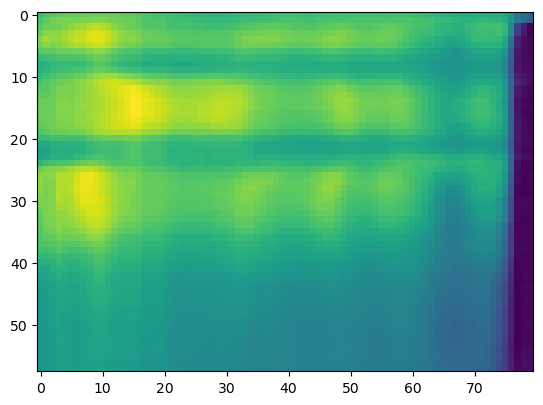

In [50]:
plt.figure()
plt.imshow(spectrogram.cpu())
plt.show()

<div class="flex justify-center">
    <img src="https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/transformers/tasks/tts_logmelspectrogram_2.png" alt="Generated log-mel spectrogram"/>
</div>

Finally, use the vocoder to turn the spectrogram into sound.

In [51]:
from transformers import SpeechT5HifiGan

vocoder = SpeechT5HifiGan.from_pretrained("microsoft/speecht5_hifigan").to(torch.device("cuda"))

In [52]:
with torch.no_grad():
    speech = vocoder(spectrogram).to(torch.device("cuda"))

from IPython.display import Audio

Audio(speech.cpu().numpy(), rate=16000)

In [53]:
# # Save Audio

# import soundfile as sf
# sf.write("tts_example.wav", speech.cpu().numpy(), samplerate=16000)

In [45]:
trainer.evaluate()

{'eval_loss': 0.45123448967933655}